# TP 2 - Séance 1
## Filtrage fréquentiel 2D

Équipe #22
- Beaudry, Sophie (2140839)
- Lachapelle, Vincent (2206192)

In [1]:
# Importe les modules qui seront utilisés dans le laboratoire.
from typing import Optional, Tuple
import numpy as np
from scipy.ndimage import convolve
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

%matplotlib inline
# Étend la taille des figures
plt.rcParams["figure.figsize"] = (18, 8)

<font color='green'>Conseil : </font>Nous vous conseillons d'utiliser la [plateforme](https://clementpla.github.io/ComputerVisionToolbox/home) de traitement d'image présentée par Clément Playout dans le cours, particulièrement le module sur la transformée de Fourier 2D. Vous pouvez vous-même créer des signaux sinusoïdaux (en cliquant sur le bouton Draw sin(x)), changer l'angle, et visualiser le résultat de la fft 2D. 

# Exercice I : FFT de signaux théoriques 2D

On étudie le signal: $S_1(x,y)=\cos(2\pi\,(x f_x + y f_y))$ paramétré par les fréquences $f_x$ et $f_y$.

On vous fournit les fonctions ```S1(fx,fy)``` qui calcule le signal avec un échantillonage $F_e=100 px/mm$, et ```plot_fft2(fft_signal)``` qui prend en paramètre une transformée de Fourier et affiche le spectre associé.

In [2]:
def plot_fft2(
    fft_signal: np.ndarray,
    Fe: Optional[float] = None,
    grid: bool = True,
    logscale: bool = False,
    ax: Optional[matplotlib.axes.Axes] = None,
) -> None:
    """Trace le spectre d'un signal à partir de sa transformée de Fourier.

    Args:
        fft_signal (np.ndarray): Transformée de Fourier du signal à afficher (array 2D complexe).
        Fe (float, optionnel): Fréquence d'échantillonage du signal. La valeur par défaut est None.
        grid (bool, optionnel): Si vrai, affiche une grille sur le spectre. La valeur par défaut est True.
        logscale (bool, optionnel): Si vrai, les intensités du spectre sont affichées en échelle logarithmique. La
            valeur par défaut est False
        ax : Si fourni, le spectre sera tracé dans ce subplot. La valeur par défaut est None.
    """
    # Si aucun système d'axes est fourni on en créé un.
    if ax is None:
        fig, ax = plt.subplots()

    # On calcule les bornes des abscisses et des ordonnées à partir de Fe.
    H, W = fft_signal.shape
    if Fe is not None:
        ymax = (H - (0 if H % 2 else 1)) / (2 * H) * Fe
        xmax = (W - (0 if W % 2 else 1)) / (2 * W) * Fe
        extent = (-Fe / 2, xmax, ymax, -Fe / 2)
    else:
        extent = (-W // 2, W // 2 + (W % 2), H // 2, -H // 2 - (H % 2))

    if grid:
        # Si grid est vrai, on affiche la grille
        ax.grid(color="#bbb", linestyle="dotted")
        unit = " (en $mm^{-1}$)" if Fe is not None else ""
        ax.set_xlabel("U" + unit)
        ax.set_ylabel("V" + unit)
    else:
        # Sinon on désactive les axes
        ax.axis("off")

    # On calcule le spectre (le module de la transformée de Fourier).
    fft_displayed = np.abs(fft_signal)

    if not logscale:
        # Si logscale est faux on affiche le spectre avec une colorbar
        graph = ax.imshow(fft_displayed, cmap="inferno", extent=extent)
        plt.colorbar(graph, ax=ax, fraction=0.0467, pad=0.02)
    else:
        # Sinon on nivelle les intensités trop élevées (0.1% des intensités les plus fortes)
        fft_displayed = np.clip(fft_displayed, 0, np.percentile(fft_displayed, 99.9))
        # et on affiche le spectre en intensités logarithmiques
        fft_displayed = np.log(1 + fft_displayed)
        graph = ax.imshow(fft_displayed, cmap="inferno", extent=extent, vmin=0)


def S1(fx: float, fy: float) -> np.ndarray:
    """Génère le signal S1 sur [-1, 1] x [-1, 1] avec une fréquence d'échantillonnage de 100 px/mm.

    Args:
        fx (float): Fréquence du signal en x.
        fy (float): Fréquence du signal en y.

    Returns:
        np.ndarray: Le signal S1.
    """
    y = np.arange(-1, 1, 1 / 100)
    x = np.arange(-1, 1, 1 / 100)
    # On définit une grille de coordonnées x et y.
    x, y = np.meshgrid(x, y)

    # On calcule le signal pour chaque point de cette grille, c'est-à-dire pour chaque pixel de l'image.
    return np.cos(2 * np.pi * (x * fx + y * fy))

**1a.** Implémentez la fonction `compute_fft2(signal)` qui prend en argument une image et calcule sa transformée de Fourier (normalisée et avec son origine centrée).  

**1b.** En prenant $f_x = 13 \text{ mm}^{-1}$ et $f_y=0$. Affichez le signal $S_1(x,y)$ et son spectre à l'aide de `plot_fft2()`. Vérifier la position des pics et leur amplitude (donnée par la colorbar). Les valeurs des positions et d'amplitude sont-elles celles attendues ?

_(Pour gagner du temps dans la suite de l'exercice, on conseille d'encapsuler le code d'affichage d'un signal et de son spectre dans une fonction.)_

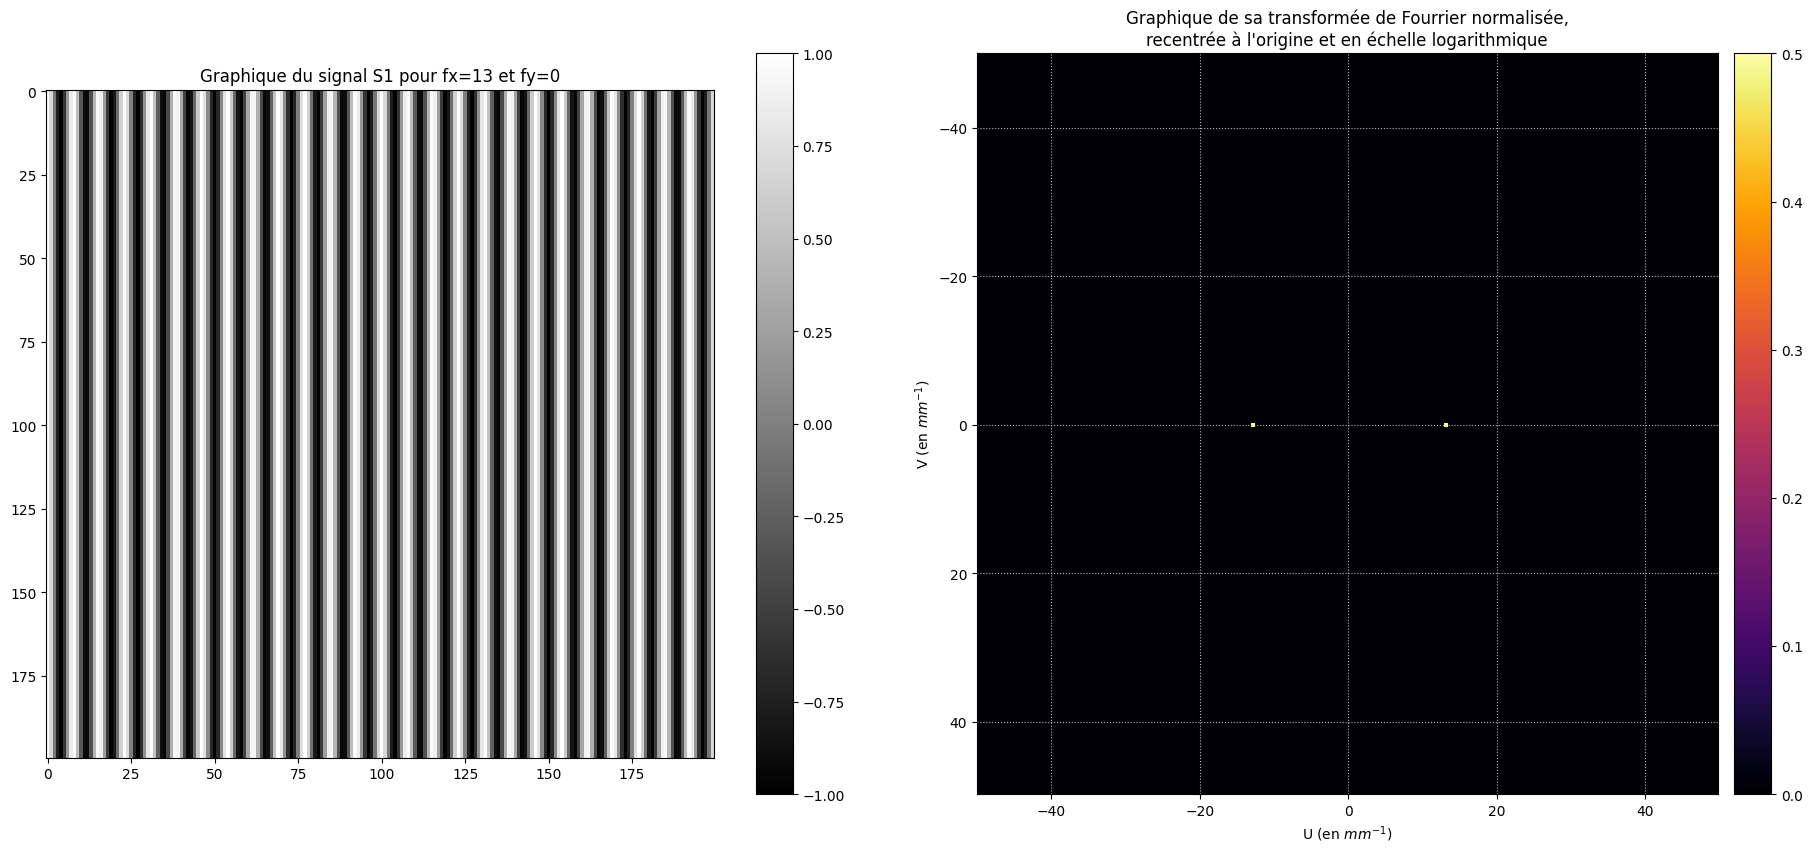

In [3]:
def compute_fft2(signal: np.ndarray) -> np.ndarray:
    # La transformée de Fourier d'une image est calculée par np.fft.fft2(img). 
    # Comme np.fft.fft() la transformée de Fourier est renvoyé entre 0<=f<Fe,
    # utilisez np.fft.fftshift pour la centrer (fréquence entre -Fe/2<=f<Fe/2).
    return np.fft.fftshift(np.fft.fft2(signal, norm="forward"))

def plot_signal_et_fft(signal: np.ndarray, title, logscale=False, Fe=100) -> None:    
    fft_signal = compute_fft2(signal)

    fig, [ax_signal, ax_fft] = plt.subplots(1,2)
    fig.tight_layout(h_pad=2.0)

    ax_signal.set_title(f"Graphique du signal {title}")
    signal_data = ax_signal.imshow(signal, cmap="gray")
    fig.colorbar(signal_data, ax=ax_signal)

    ax_fft.set_title("Graphique de sa transformée de Fourrier normalisée,\nrecentrée à l'origine et en échelle logarithmique")
    plot_fft2(fft_signal, Fe=Fe, logscale=logscale, ax=ax_fft) 

signal_1b = S1(13, 0)
plot_signal_et_fft(signal_1b, "S1 pour fx=13 et fy=0")


Comme le signal étudié est un cosinus de fréquence $13 \text{ px}^{-1}$ dans la direction $x$, alors sa transformée de Fourier devrait être simplement deux impulsions à cette même fréquence. Selon le théorème de Nyquist, la fréquence maximale pouvant être observe dans une grille de 100 pixel est de 50 $\text{ px}^{-1}$. Comme l'échelle de fréquence est normalisé, on voit que le graphique du spectre ressemble exactement à celui attendu.

**2a.** Affichez $S_1$ et son spectre pour $f_x=0$, $f_y=13 \text{ px}^{-1}$ puis pour $f_x=5 \text{ px}^{-1}$, $f_y=12 \text{ px}^{-1}$.   

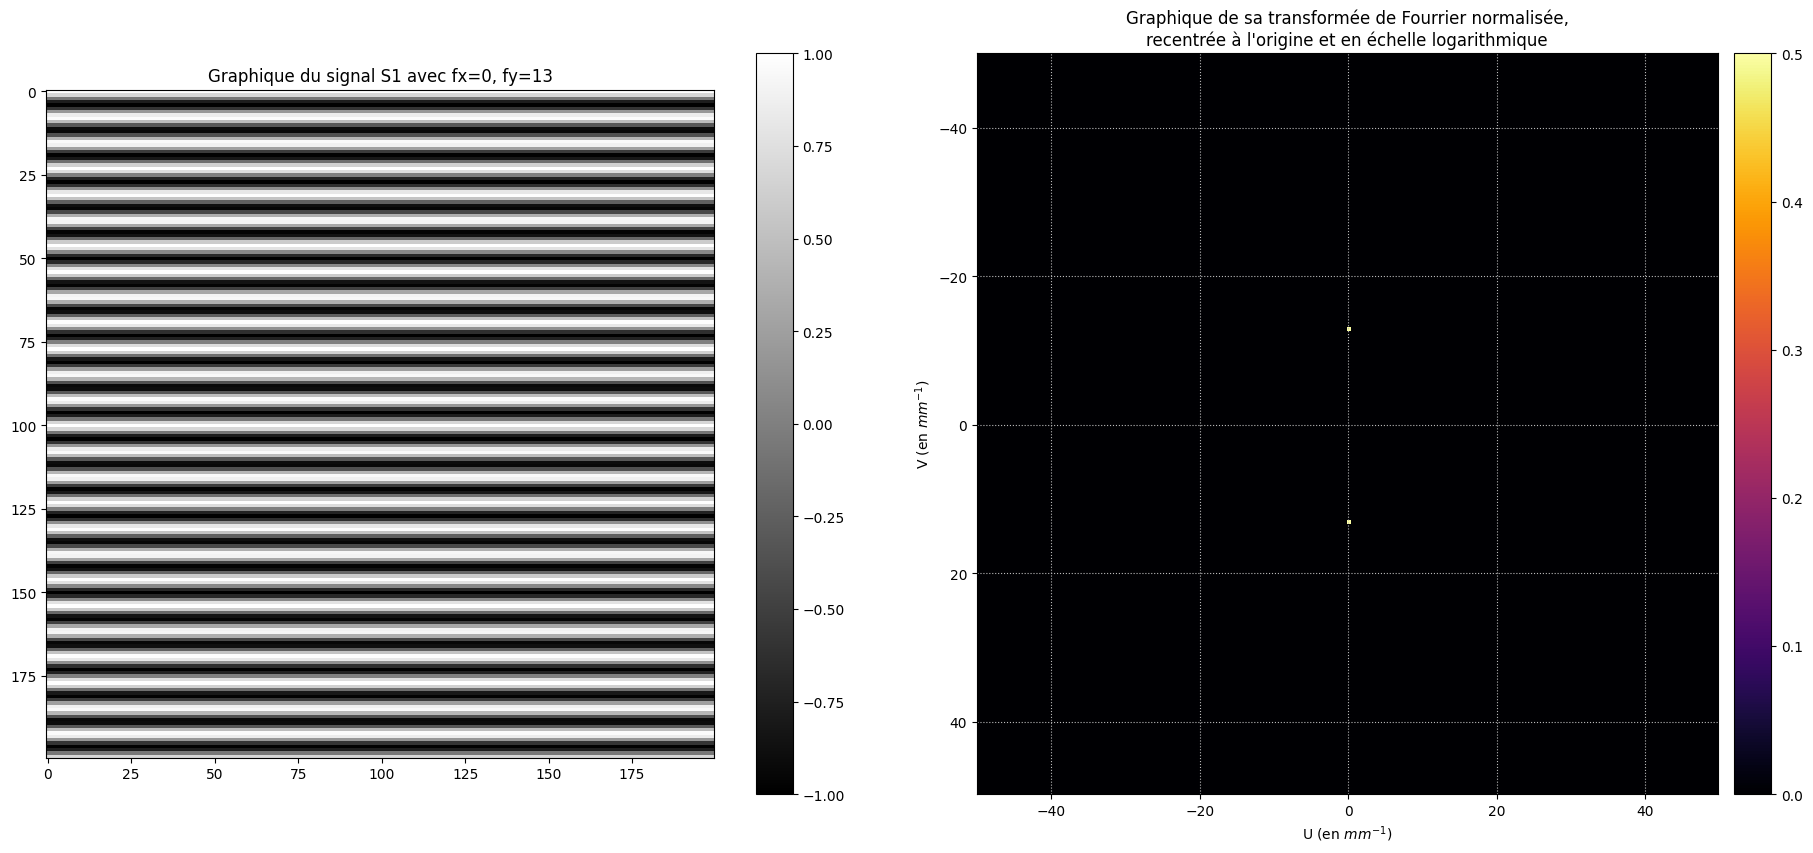

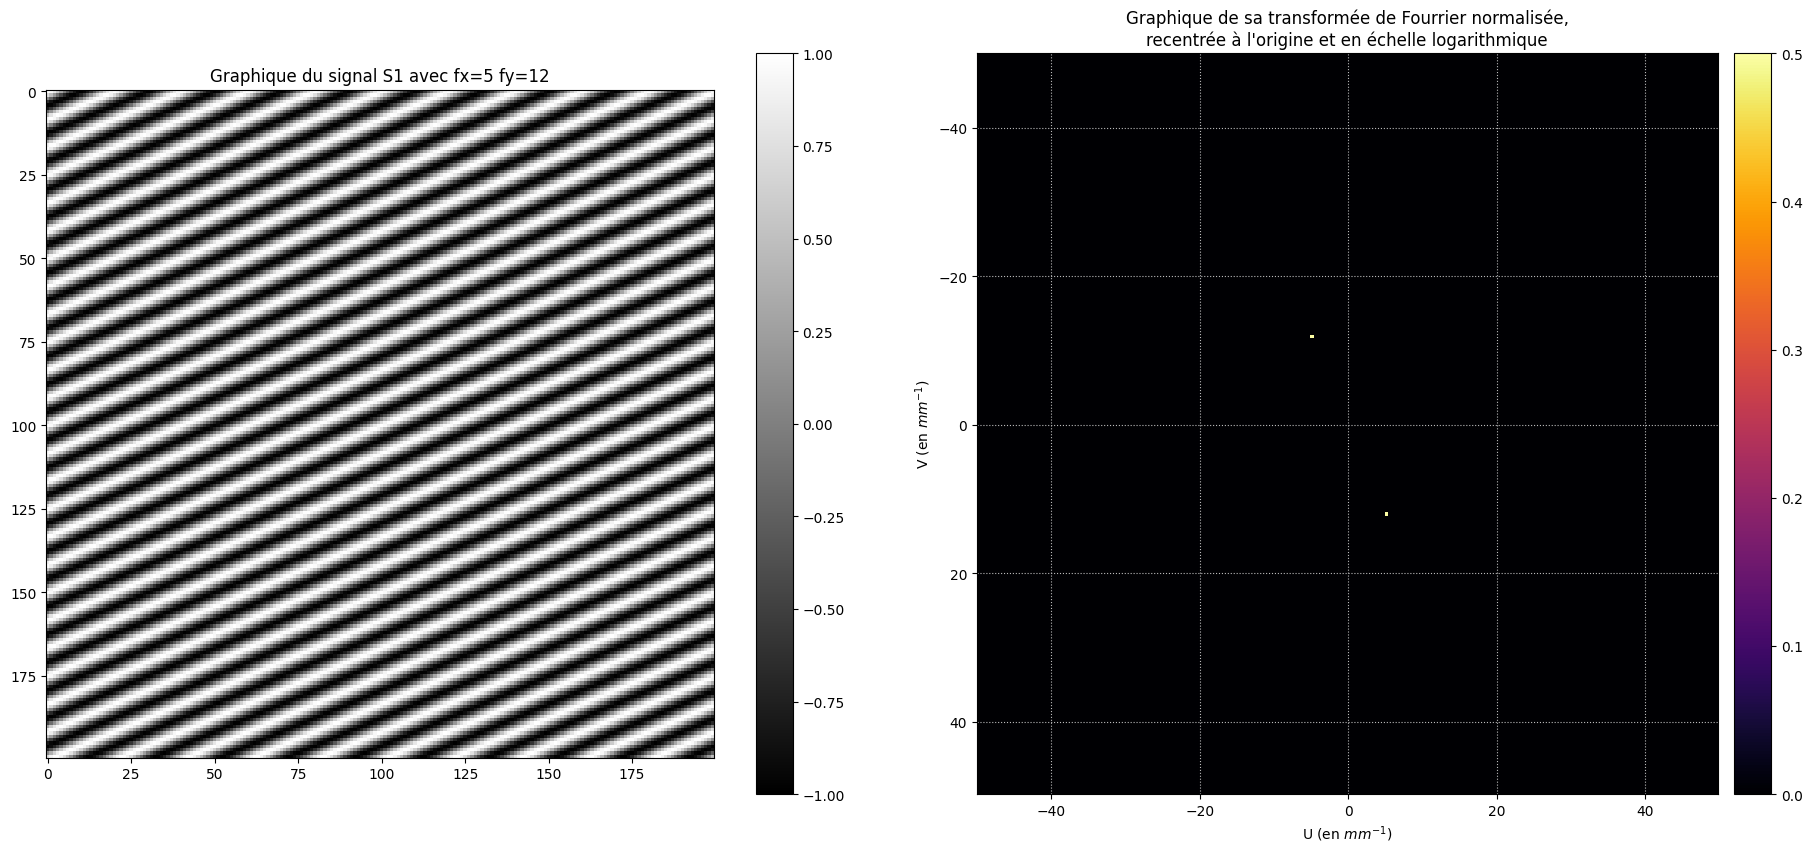

In [4]:
signal_2a1=S1(0, 13)
signal_2a2=S1(5, 12)
plot_signal_et_fft(signal_2a1, "S1 avec fx=0, fy=13")
plot_signal_et_fft(signal_2a2, "S1 avec fx=5 fy=12")


**2b.** Quel est l'effet d'une rotation de l'image sur son spectre?

Lorsque qu'une image subit une rotation, son spectre subit la même rotation dans le même sens.

La prochaine question étudie le signal: $S_2(x,y) = cos(2\pi f r)$ où $r=\sqrt{x^2+y^2}$.

**3a.** En vous inspirant de l'implémentation de ```S1(fx,fy)```, définissez ```S2(f)``` (pour mieux comprendre voir la doc de [np.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)).  
Affichez le signal et son spectre pour $f=20$ et pour $f=40$.   

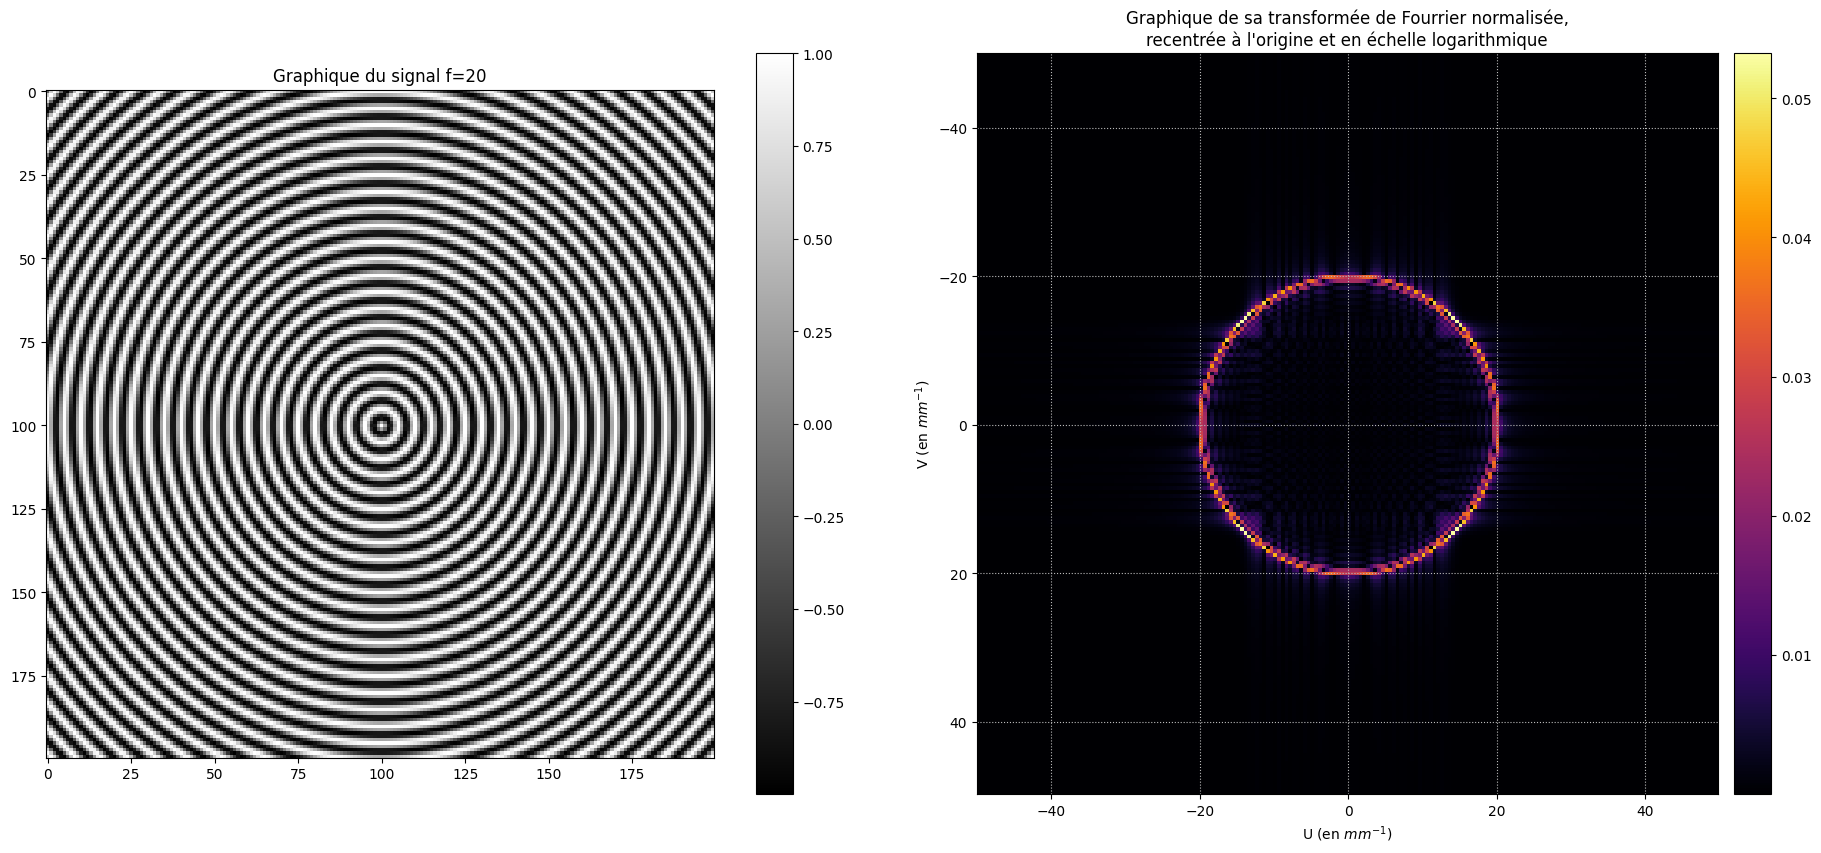

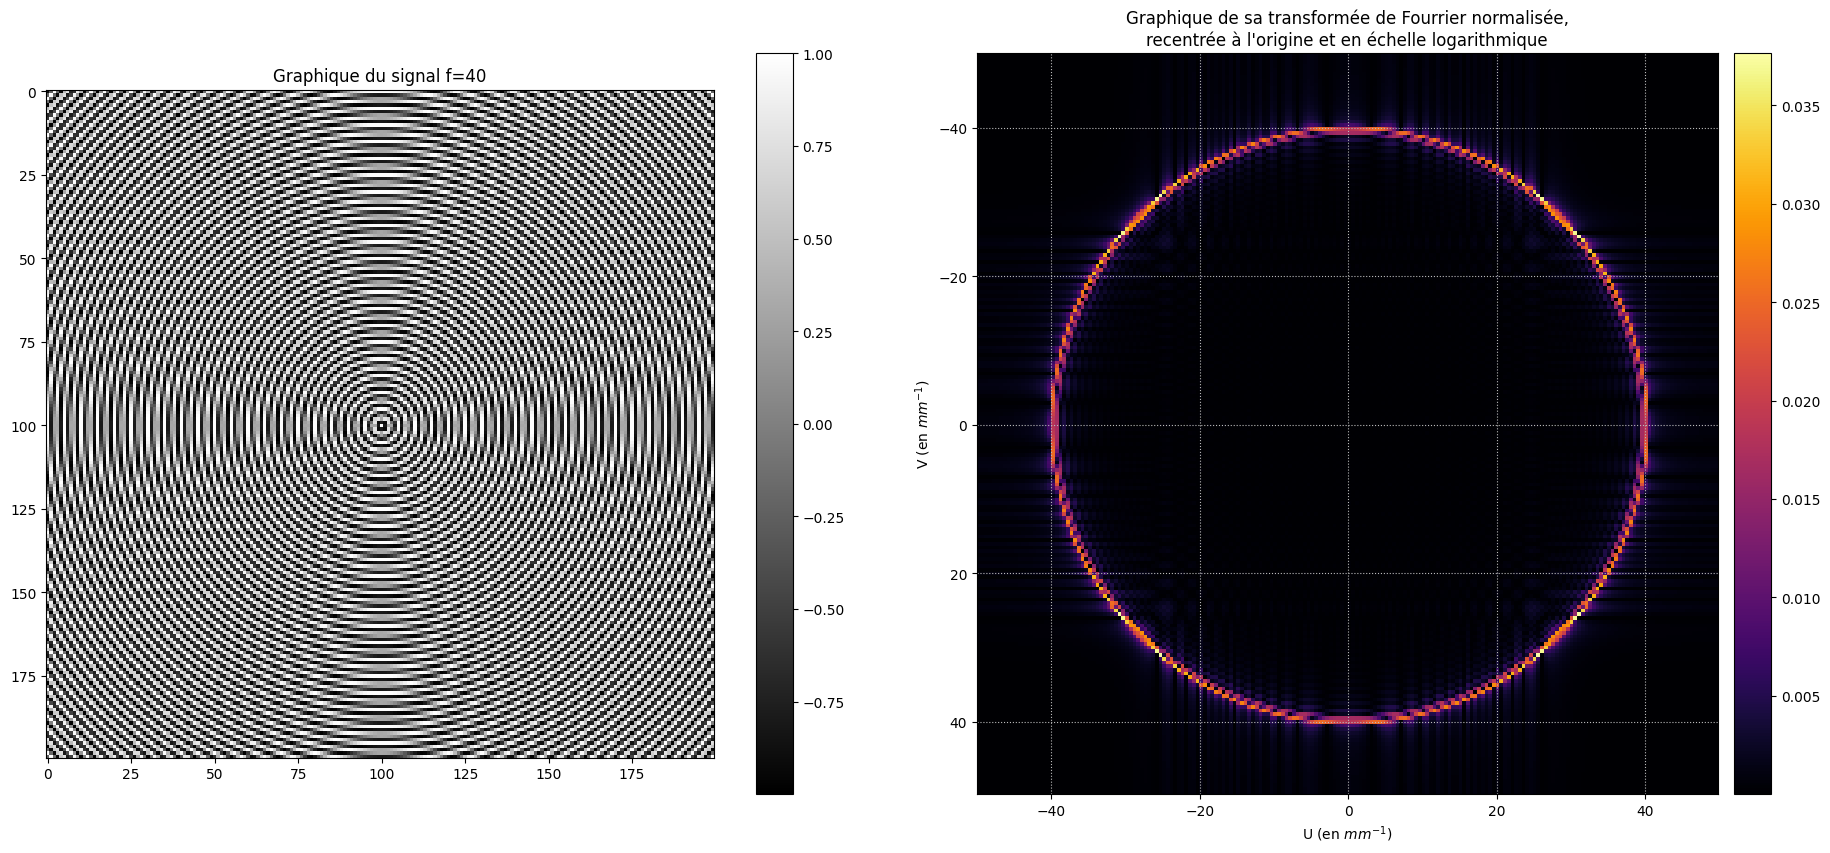

In [5]:
def S2(f: float) -> np.ndarray:
    """Génère le signal S2 sur [-1, 1] x [-1, 1] avec une fréquence d'échantillonnage de 100 px/mm.

    Args:
        f (float): Fréquence du signal en x et en y.

    Returns:
        np.ndarray: Le signal S2.
    """
    
    y = np.arange(-1, 1, 1 / 100)
    x = np.arange(-1, 1, 1 / 100)
    # On définit une grille de coordonnées x et y.
    x, y = np.meshgrid(x, y)

    # On calcule le signal pour chaque point de cette grille, c'est-à-dire pour chaque pixel de l'image.
    return np.cos(2 * np.pi *f*(np.sqrt(x**2+y**2)))
signal_3a1=S2(20)
signal_3a2=S2(40)
plot_signal_et_fft(signal_3a1, 'f=20')
plot_signal_et_fft(signal_3a2, 'f=40')


**3b.** Quel est l'effet d'un rétrécissement de l'image sur son spectre? 

Le rétrécissement d'une image augmente son spectre fréquentiel selon la propriété de scaling de la transformée de Fourrier

**3c.** Affichez le signal et le spectre pour $f=120$. Expliquez l'allure du spectre et les aberrations visibles sur le signal.

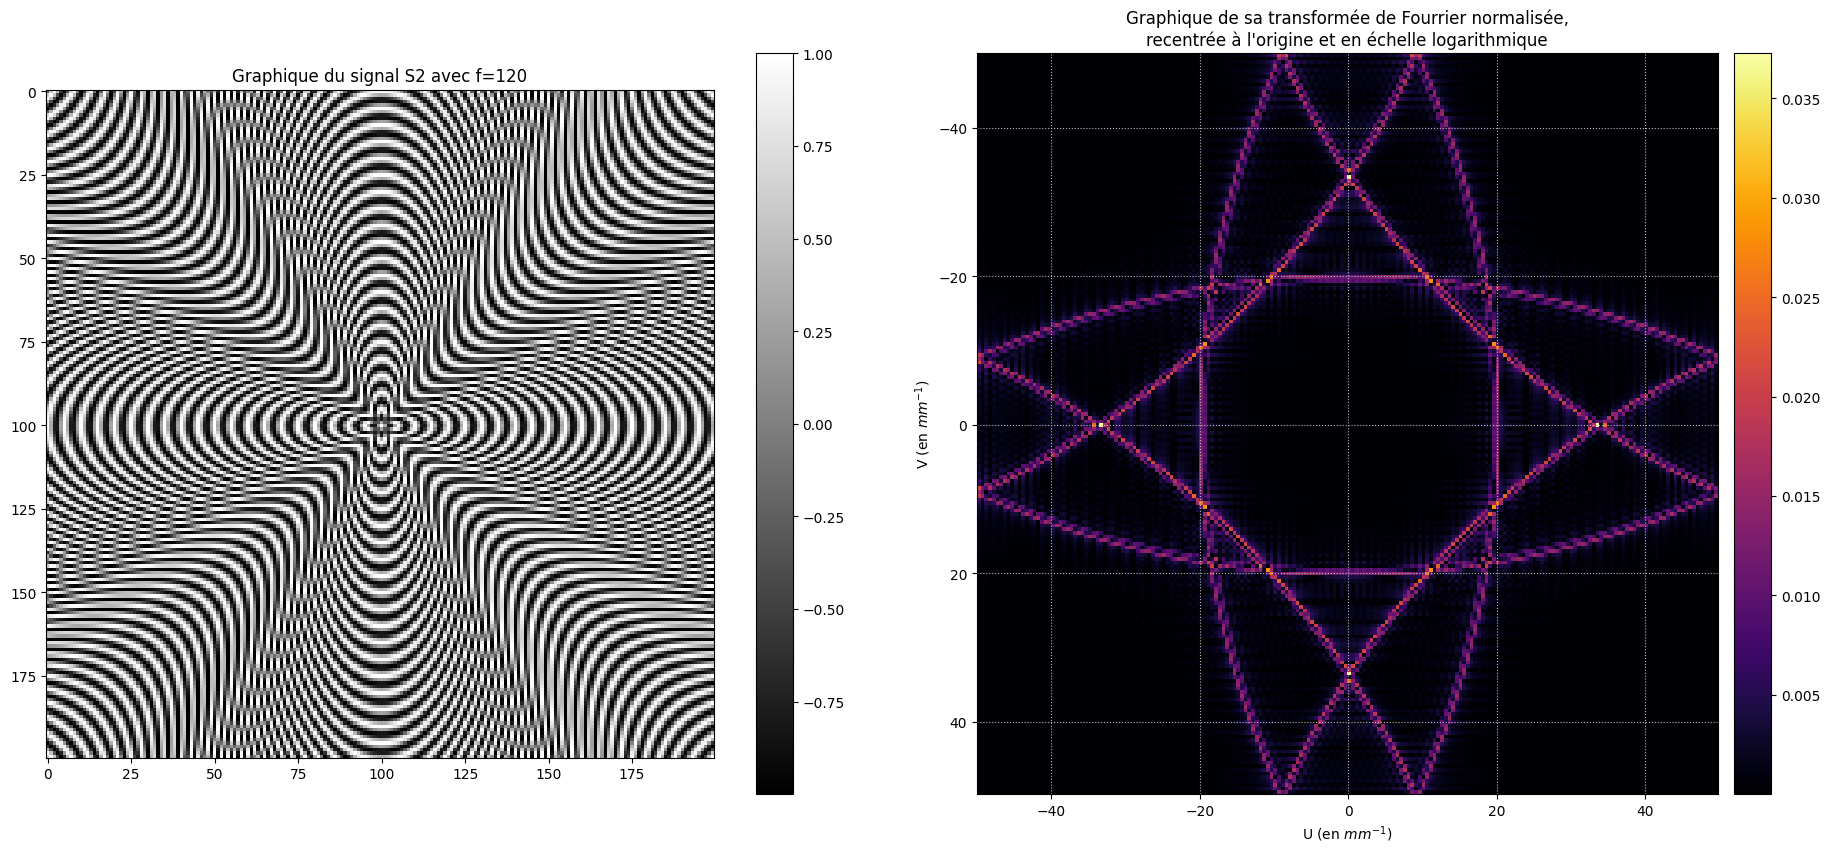

In [6]:
signal_3c = S2(120)
plot_signal_et_fft(signal_3c, "S2 avec f=120")

Lorsque la fréquence du signal dépasse la fréquence d'échantillonage, alors il y a aliasing du signal dans sa transformée de Fourier. Ainsi, les parties de hautes fréquences provenent des motifs adjacents se superposent aux motifs principals, ce qui déteriore le signal et crée des aberrations dans ce dernier.

____

# Exercice II : Filtrage spectral

Cet exercice étudie une image angiographique du réseau coronaire: c'est-à-dire une radiographie des artères qui alimentent le coeur dans lesquelles est injecté un agent de contraste.

Tout d'abord, on souhaite définir une fonction de création de gaussienne.    
On rappelle la formule de la gaussienne en 2D d'écart-type $\sigma$ et de centre $(x_0, y_0)$: $G(x,y) = \exp\left(\dfrac{-r^2}{2 \sigma^2}\right)$ avec $r=\sqrt{(x-x_0)^2+(y-y_0)^2}$.

**1a.** Implémentez la fonction `gaussian(std, size, x0=0, y0=0)` qui renvoie une matrice de taille `size` contenant les valeurs d'une gaussienne d'écart-type `std` et centrée sur (`x0`, `y0`) avec le point central comme origine: (0,0).

**1b.** Calculez une gaussienne centrée, d'écart-type 7 dans une matrice 300x300. Affichez son image et son spectre.

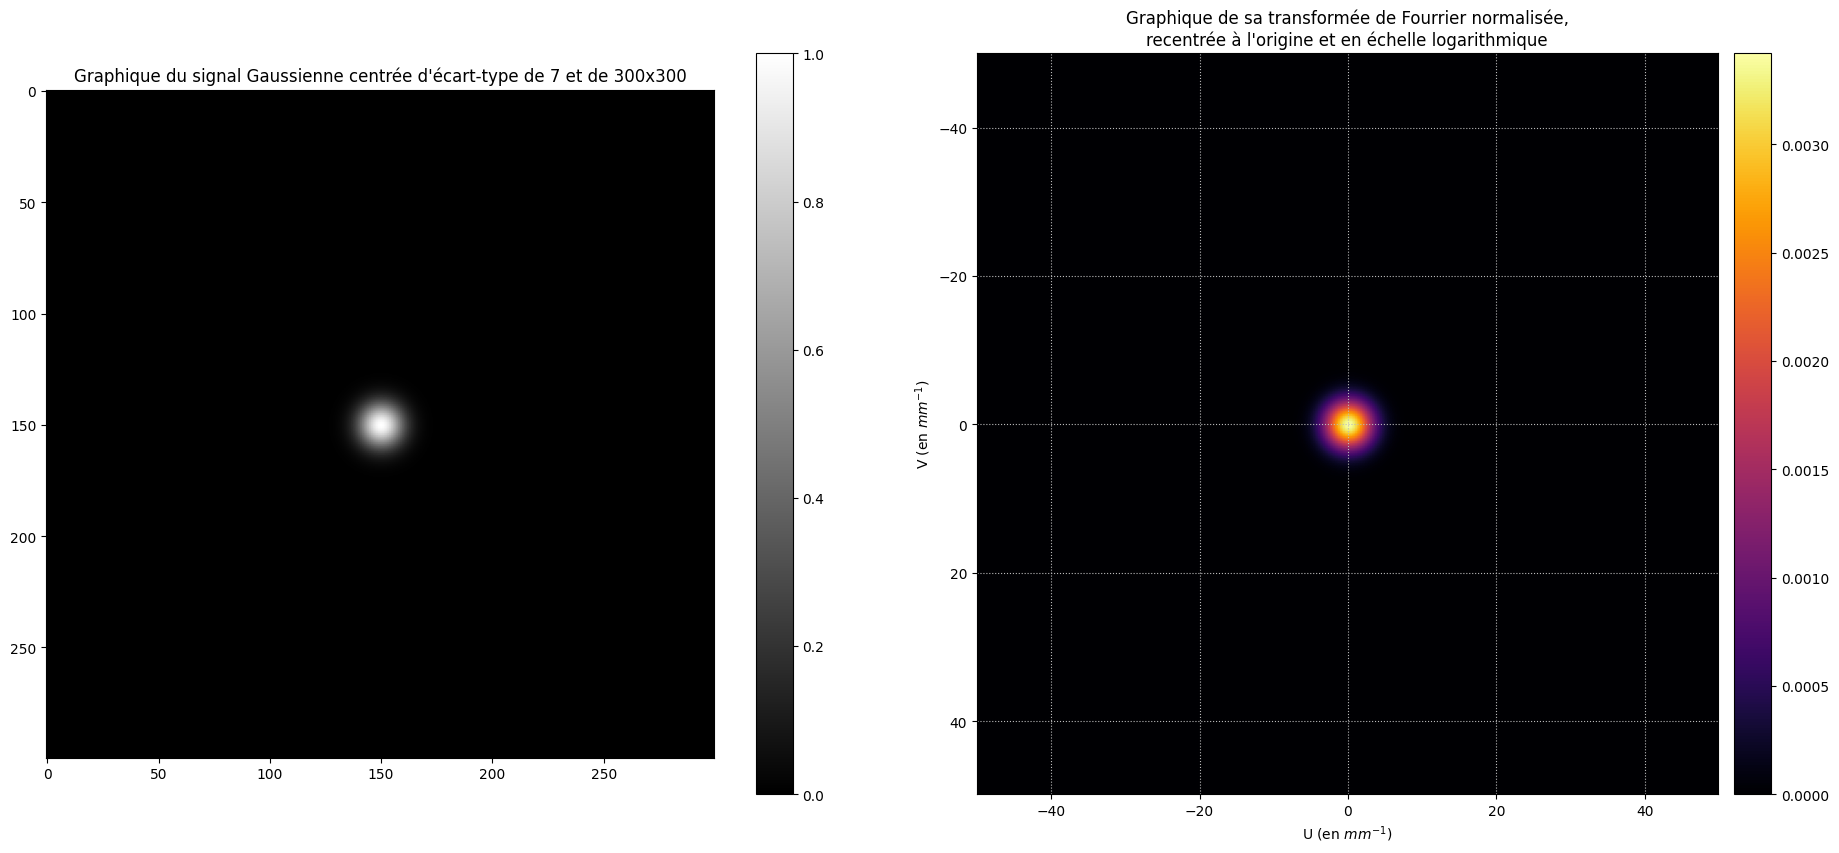

In [7]:
def gaussian(std: float, size: int, x0: float = 0, y0: float = 0) -> np.ndarray:
    """Génère une matrice carrée qui contient une gaussienne centrée en (x0, y0) avec un écart-type de std.

    Args:
        std (float): écart-type de la gaussienne.
        size (int): taille de la matrice carrée.
        x0 (float, optional): coordonnée x du centre de la gaussienne. La valeur par défaut est 0.
        y0 (float, optional): coordonnée y du centre de la gaussienne. La valeur par défaut est 0.

    Returns:
        np.ndarray: La gaussienne.
    
    """
    y = np.arange(-size/2, size/2, 1)
    x = np.arange(-size/2, size/2, 1)
    # On définit une grille de coordonnées x et y.
    x, y = np.meshgrid(x, y)
    return np.exp((-((x-x0)**2+(y-y0)**2))/(2*std**2))
gauss_II1b=gaussian(7,300,0,0)
plot_signal_et_fft(gauss_II1b, "Gaussienne centrée d'écart-type de 7 et de 300x300")



**2.** Chargez l'image `angiographie_bruit.png`. Affichez l'image et son spectre.   
Identifiez sur le spectre les raies qui sont responsables des rayures diagonales sur l'angiographie (donnez les coordonnées des points concernés). 

_Pour améliorer la lisibilité du spectre, activez l'option `logscale=True`. Cette option sera laissée active dans les prochaines questions pour l'affichage de tous les spectres issus de l'image._

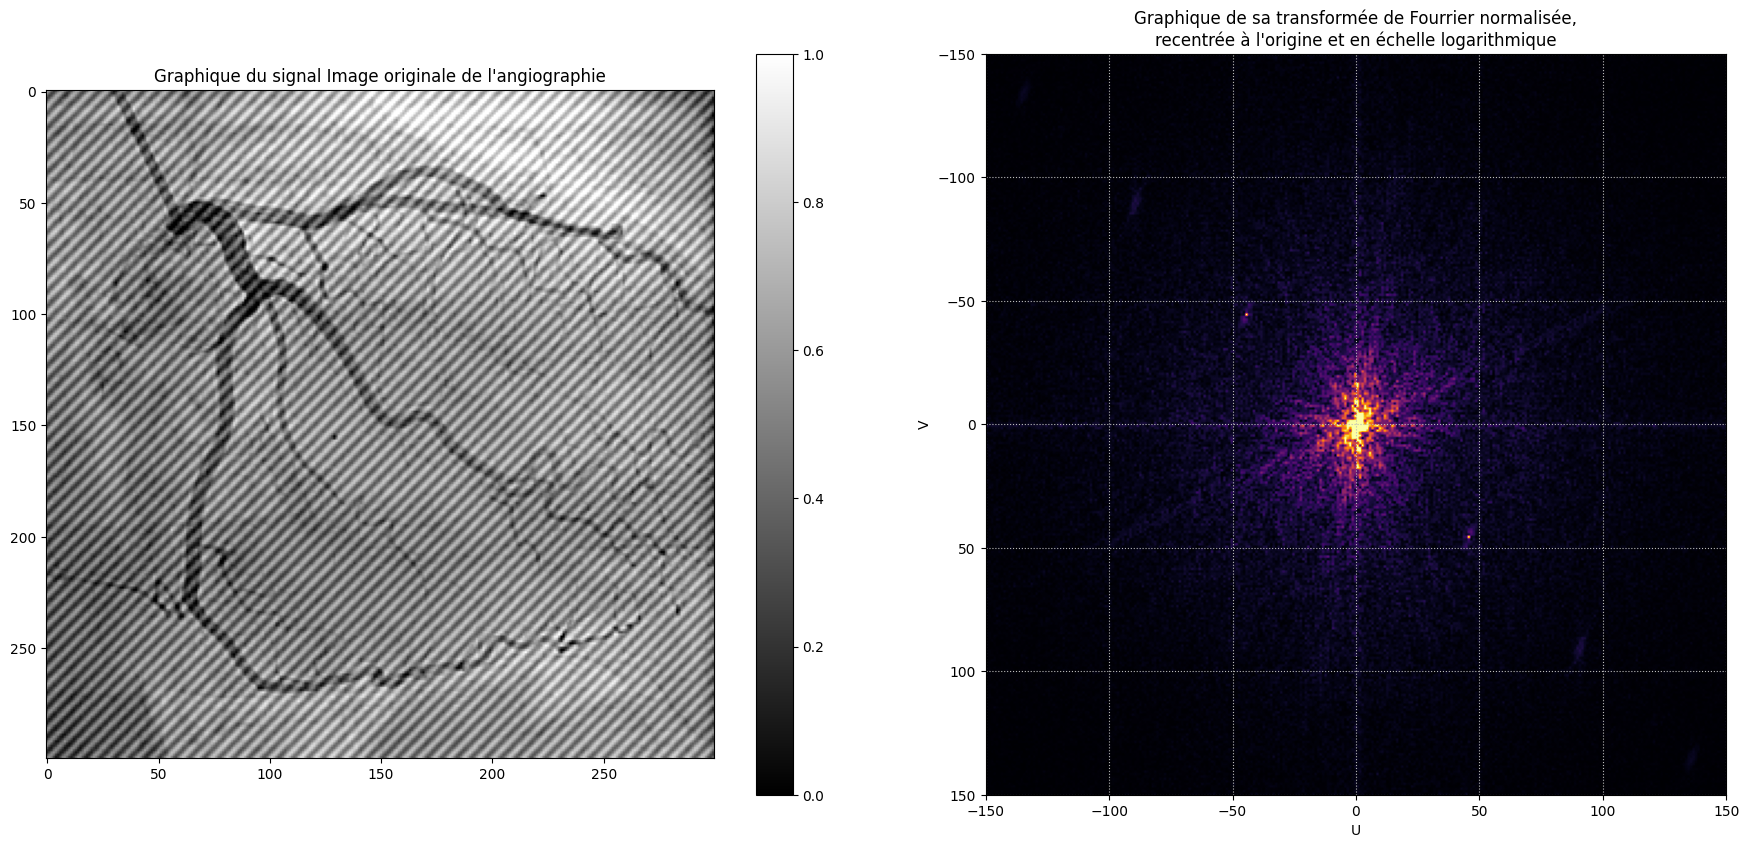

In [8]:
angio=imread("angiographie_bruit.png")
plot_signal_et_fft(angio, "Image originale de l'angiographie",logscale=True, Fe=None)


On remarque que les trais diagonals sur l'image originale se retrouvent sous forme de raies (points) aux coordonnées (-45,-45) et (45, 45) sur la transformée de Fourrier normalisée.

**3.** À l'aide de la fonction ``gaussian(std, size, x0=0, y0=0)``, concevez un masque pour filtrer ces raies directement dans le domaine de Fourier (on pourra prendre un écart type de 3 pixels.) Appliquez le masque à la transformée de Fourier de l'image.   
Affichez le masque et le spectre filtré.

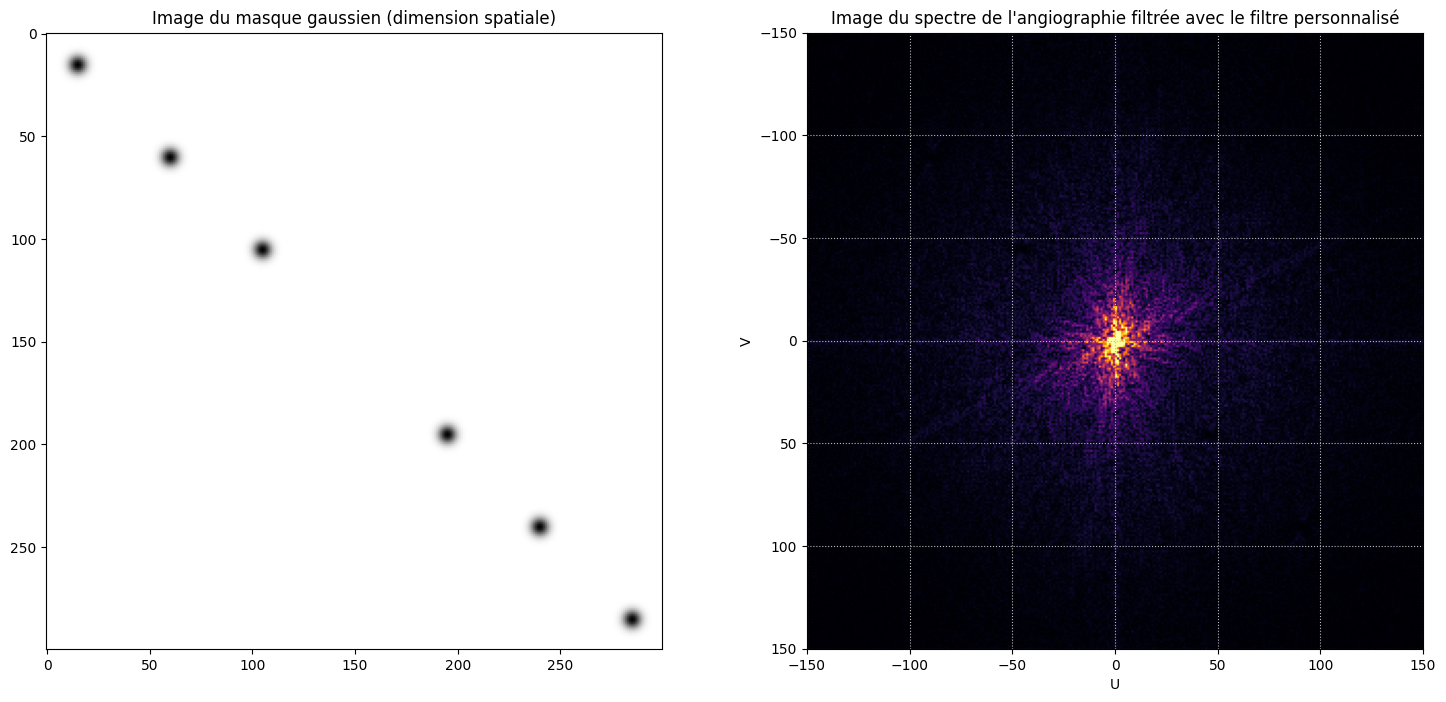

In [9]:
angio_fft=compute_fft2(angio)
masque = 1 - (gaussian(3, 300, -135, -135) + gaussian(3, 300, -90, -90) + gaussian(3, 300, -45, -45) + gaussian(3, 300, 135, 135) + gaussian(3, 300, 90, 90) + gaussian(3, 300, 45, 45))
angio_x_masque = angio_fft * masque

fig, [ax_masque, ax_spectre] = plt.subplots(1,2)

ax_masque.set_title("Image du masque gaussien (dimension spatiale)")
ax_masque.imshow(masque, cmap="gray", vmin=0.0, vmax=1.0)

ax_spectre.set_title("Image du spectre de l'angiographie filtrée avec le filtre personnalisé")
plot_fft2(angio_x_masque, logscale=True, ax=ax_spectre)

Nous avons choisi de retirer les raies aux coordonnées de (-45, -45) et (45,45), ainsi qu'aux harmoniques de ces fréquences.

**4.** Implémentez la fonction `compute_ifft2(fft_signal)` qui prend en argument la transformée de Fourier d'une image et renvoie l'image reconstituée par transformée de Fourier inverse. Reconstituez et affichez l'angiographie nettoyée de ses rayures diagonales.

Pour la suite de l'exercice on travaillera sur l'angiographie nettoyée ou sur son spectre. Sa transformée de Fourier sera notée $T_0$.

**Nous utilisons la variable «angio_x_masque» pour représenter T0.**

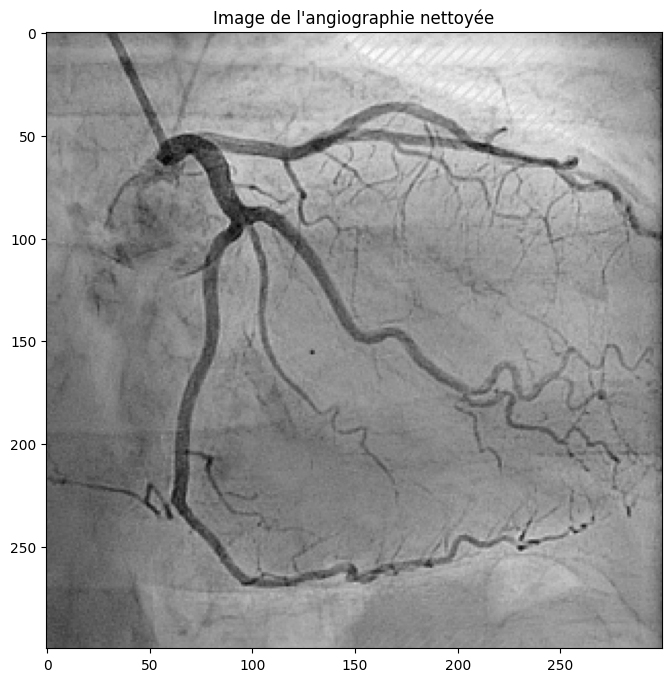

In [10]:
def compute_ifft2(fft_signal: np.ndarray) -> np.ndarray:
    # Avant d'être basculée dans le domaine spatial, les fréquences de la transformée de Fourier du signal 
    # doivent être permutées avec np.fft.ifftshift pour être à nouveau comprises entre 0 <= f < Fe.
    # La transformée de Fourier inverse d'une image est calculée par np.fft.ifft2(img). 
    return np.fft.ifft2(fft_signal, norm="forward")

angio_filtree = compute_ifft2(angio_x_masque)

plt.title("Image de l'angiographie nettoyée")
plt.imshow(np.abs(angio_filtree), cmap="gray")

On souhaite appliquer un filtre passe-bas dont la réponse fréquentielle est une gaussienne centrée sur l'origine d'écart-type 25.

**5.** Créez le masque gaussien correspondant, appliquez le à la transformée de Fourier de l'image et reconstituez la. Affichez l'image reconstituée et son spectre. 

On notera $T_{\text{LF}}$ la transformée de Fourier après ce filtrage.

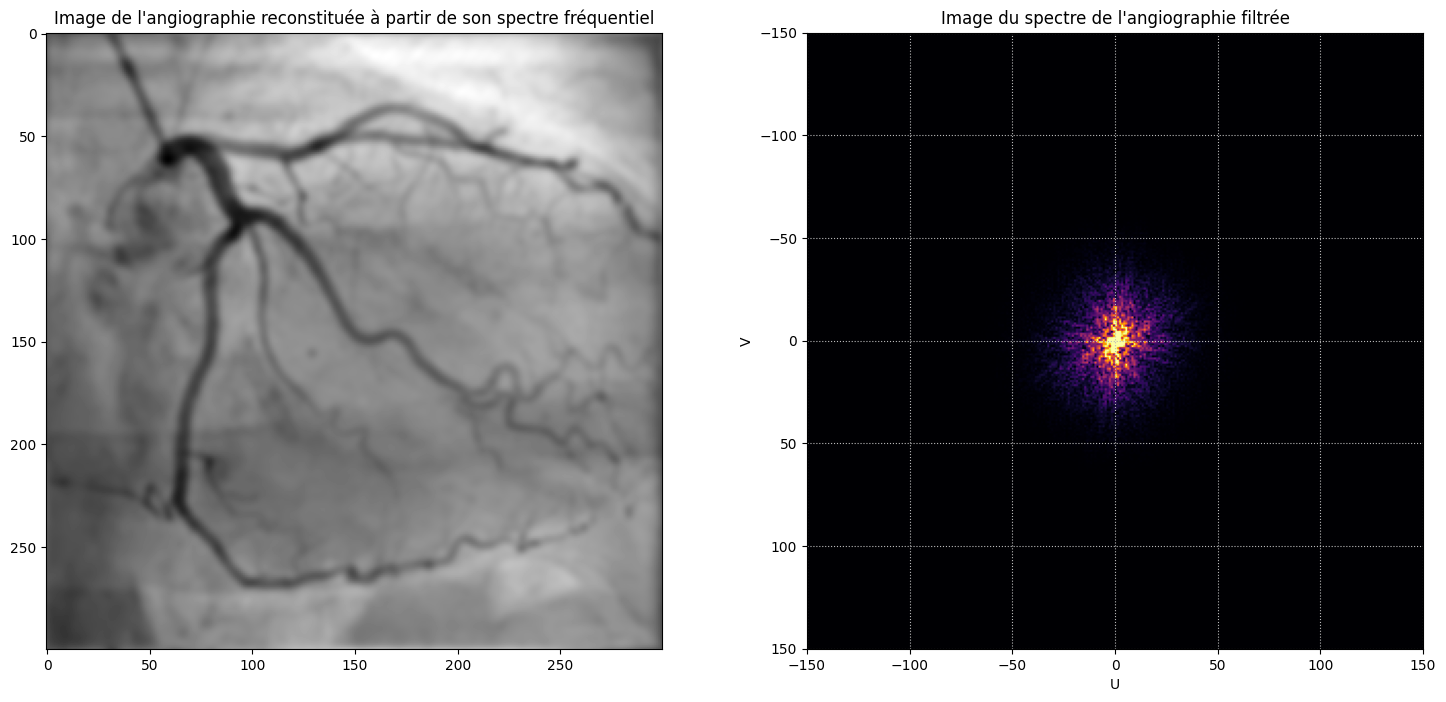

In [11]:
gauss_II5_fft = gaussian(25,300,0,0)
fft_TLF = gauss_II5_fft * angio_x_masque

fig, [ax_img, ax_spectre] = plt.subplots(1,2)

ax_img.set_title("Image de l'angiographie reconstituée à partir de son spectre fréquentiel")
ax_img.imshow(np.abs(compute_ifft2(fft_TLF)), cmap="gray")

ax_spectre.set_title("Image du spectre de l'angiographie filtrée")
plot_fft2(fft_TLF, logscale=True, ax=ax_spectre)

**6a.** Calculez l'intensité des fréquences qui ont été retirées du spectre à la question précédente, c'est-à-dire la transformée de Fourier $T_{\text{HF}}$ telle que $T_0 = T_{\text{LF}} + T_{\text{HF}}$.   
Affichez l'image reconstituée et son spectre. 

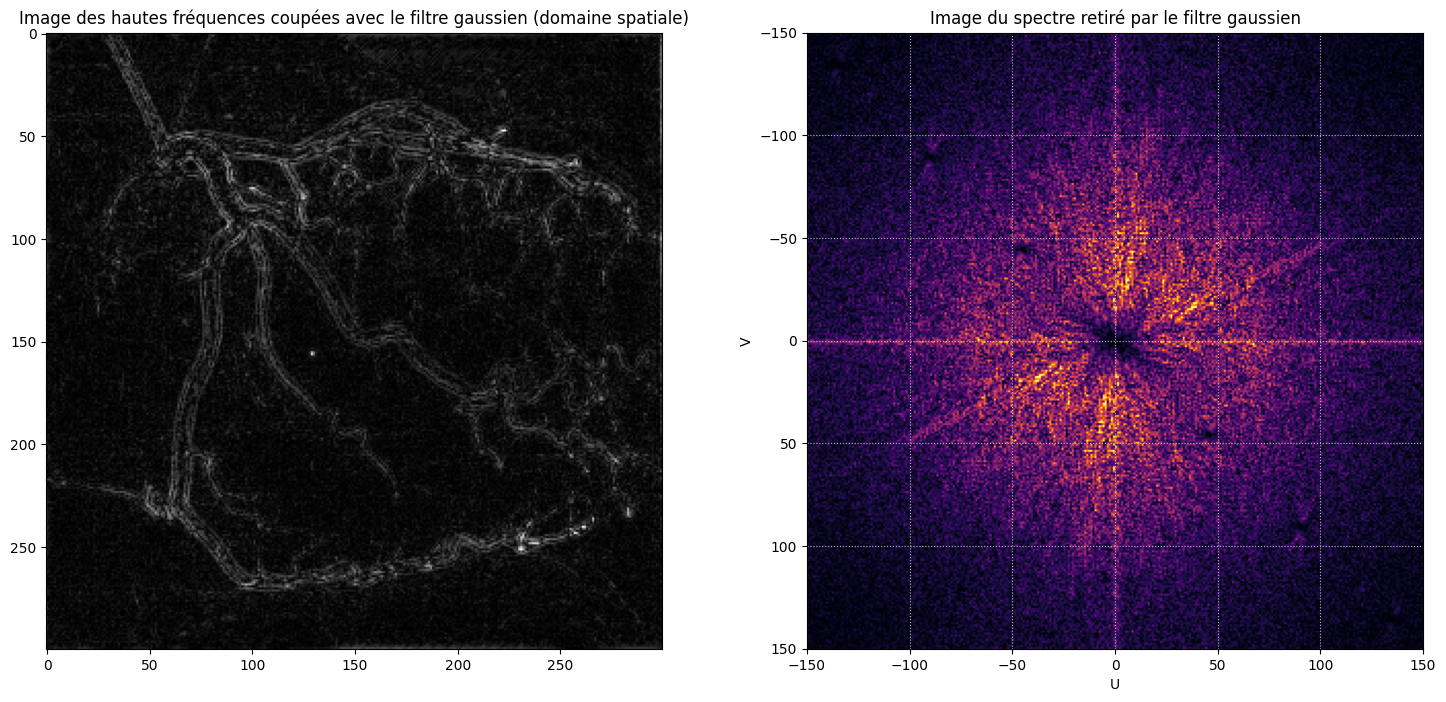

In [12]:
fft_THF = angio_x_masque - fft_TLF

fig, [ax_img, ax_spectre] = plt.subplots(1,2)

ax_img.set_title("Image des hautes fréquences coupées avec le filtre gaussien (domaine spatiale)")
ax_img.imshow(np.abs(compute_ifft2(fft_THF)), cmap="gray")

ax_spectre.set_title("Image du spectre retiré par le filtre gaussien")
plot_fft2(fft_THF, logscale=True, ax=ax_spectre)

**6b.** Quel est le type de ce filtrage?

C'est un filtre passe-haut, car seul les contours fins de l'image sont conservés.

**7.** Créez un masque gaussien centré d'écart-type 1.91 pixels, de taille 11x11 et normalisé pour que sa somme soit 1. Convoluez ce masque avec l'image nettoyée à la question 4.   
Affichez l'image filtrée et son spectre.

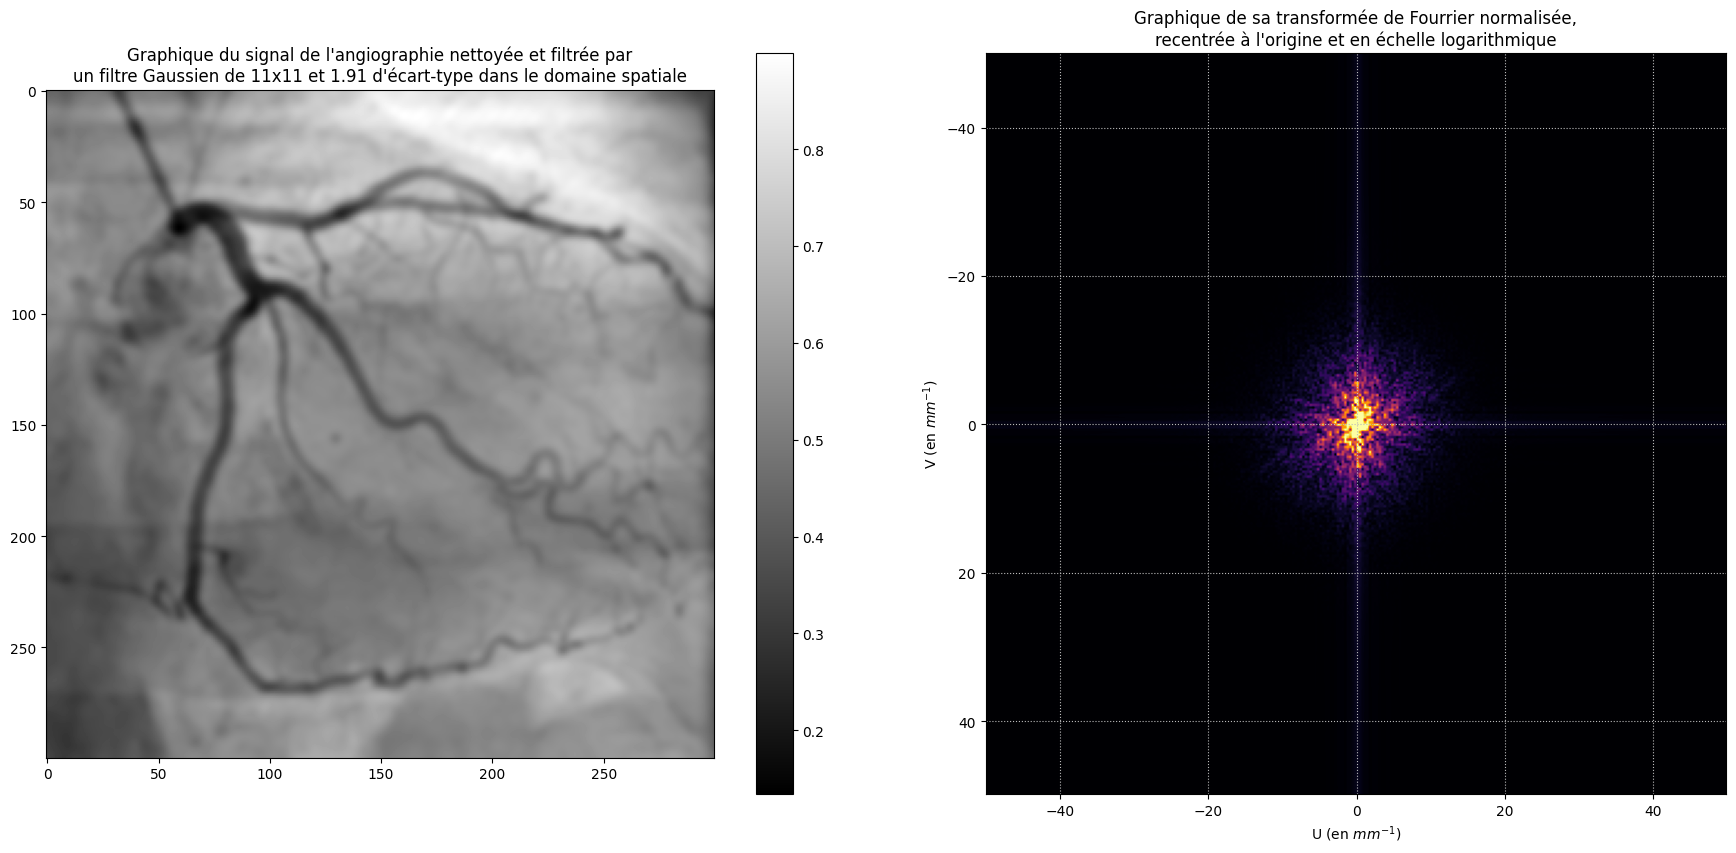

In [13]:
masque_gauss_7 = gaussian(1.91, 11, 0, 0)
masque_gauss_7 = masque_gauss_7/np.sum(masque_gauss_7)

img_filtre = convolve(np.abs(angio_filtree), masque_gauss_7, mode='nearest')
plot_signal_et_fft(img_filtre, "de l'angiographie nettoyée et filtrée par\nun filtre Gaussien de 11x11 et 1.91 d'écart-type dans le domaine spatiale", logscale=True)


On rappelle que la transformée de Fourier d'une gaussienne d'écart-type $\sigma_0$ est un gaussienne d'écart-type $\frac{1}{2 \pi \sigma_0}$. Notons aussi que l'écart-type du masque de la question 5 en $\text{px}^{-1}$ est de $\frac{25}{300}$, c'est-à-dire l'écart-type de la gaussienne divisé par le nombre de pixel de la largeur (ou de la hauteur) du spectre.


**8a.** Démontrez mathématiquement l'équivalence entre les filtrages réalisés aux question 5 et 7.



In [14]:
ecart_type_fft = 1/(2*np.pi*1.91)
print(f"L'écart-type de la gausienne spatiale utilisé à la question 7 est de {ecart_type_fft:.6f} dans le domaine fréquentiel,\nce qui est très près de celui utilisé à la question 5, qui est de {25/300:.6f}.")

L'écart-type de la gausienne spatiale utilisé à la question 7 est de 0.083327 dans le domaine fréquentiel,
ce qui est très près de celui utilisé à la question 5, qui est de 0.083333.


De plus, la convolution dans le domaine spatial est l'équivalent de la multiplication dans le domaine fréquentiel. Comme la transformée de Fourrier du filtre spatial ressemble au filtre fréquentiel utilisé à la question 5, alors les deux processus sont équivalents.

**8b.** Avec quel masque faut-il convoluer l'image nettoyée pour réaliser un filtrage passe-haut équivalent à celui de la question 6 mais dans le domaine spatial?

Il faut convoluer l'image par la différence entre le masque identité et le masque gaussien de la question 7, soit : $\delta_{11 \times 11}(x,y) - h_{gauss, 11 \times 11}(x,y)$

**Bonus**

Calculez et affichez la transformée de Fourier de l'image `cellules.png`. Cette image représente une certaine lignée cellulaire imagée au microscope. Est-ce que la méthode implémentée dans l'exercice II permettrait d'éliminer les lignes qui perturbent l'image ? En quoi le spectre de la FFT est-il différent de l'image angiographique de l'exercice II ?


In [15]:
from cv2 import cvtColor, COLOR_RGB2GRAY
from cv2 import imread as cv2Imread

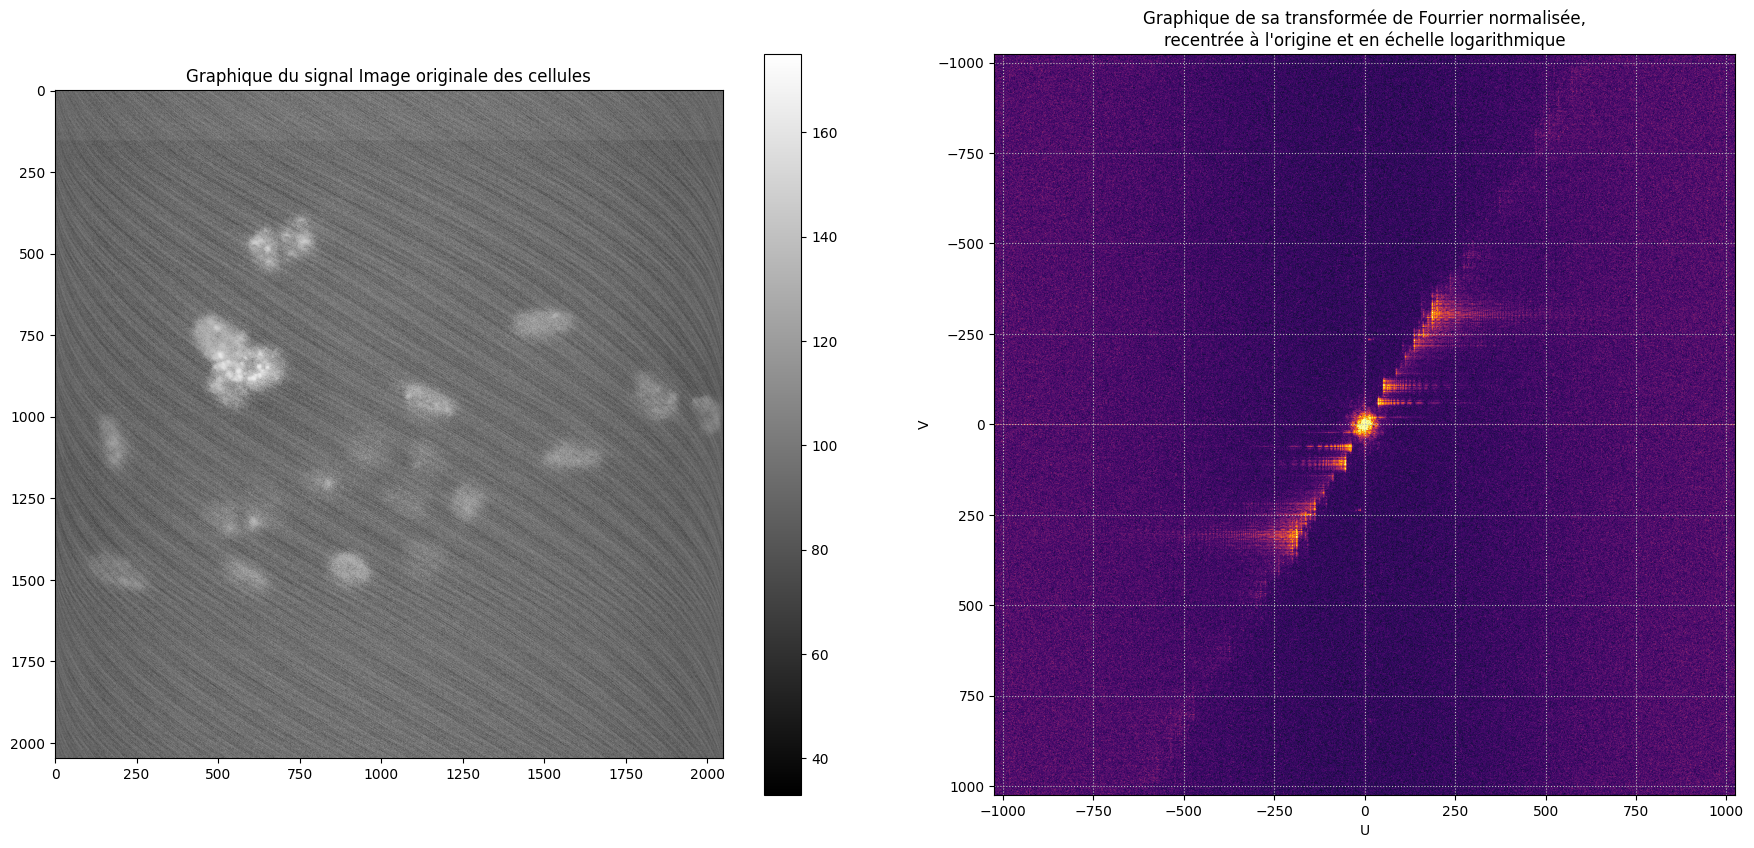

In [16]:
image = cv2Imread("cellules.png")
gray = cvtColor(image, COLOR_RGB2GRAY)

plot_signal_et_fft(gray, "Image originale des cellules",logscale=True, Fe=None)

On ne pourrait pas utiliser la même méthode, car le bruit n'est pas un sinusoïdal parfait.